1. Importing Data

Link to data: https://www.kaggle.com/datasets/boonpalipatana/nba-season-records-from-every-year/data

Process to use:
1. Go to link, hit download, and download zip.
2. Open zip file, click the file in the left side and upload the file.

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier

file = ('Team_Records.csv')
df = pd.read_csv(file)
df.head()

,Season,Lg,Team,W,L,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Playoffs,Coaches,Top WS
0,2017-18,NBA,Boston Celtics,29,10,0.744,1,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,NaN,B. Stevens (29-10),K. Irving (5.7)
1,2016-17,NBA,Boston Celtics*,53,29,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,Lost E. Conf. Finals,B. Stevens (53-29),I. Thomas (12.5)
2,2015-16,NBA,Boston Celtics*,48,34,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,Lost E. Conf. 1st Rnd.,B. Stevens (48-34),I. Thomas (9.7)
3,2014-15,NBA,Boston Celtics*,40,42,0.488,2,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,Lost E. Conf. 1st Rnd.,B. Stevens (40-42),T. Zeller (6.5)
4,2013-14,NBA,Boston Celtics,25,57,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,NaN,B. Stevens (25-57),B. Bass (5.1)


Season: NBA season
Lg: Basketball League (Must clean to make NBA only)
Team: Team name (* means playoffs made)
Win: Number of regular season wins
Loss: Number of regular season losses (Must ensure Wins + Loss = 82)
Finish: Division Ranking (Directly Correlated to playoff bid)
SRS: Simple Rating System (Combines avg margin of victory with strength of schedule)
Pace: Tempo of the game
Rel_Pace: Pace compared to rest of the league
ORtg: Offensive rating
Rel_ORtg: Offensive rating compared to avg
DRtg: Defensive rating
Rel_DRtg: Defensive rating compared to avg
Coach: Coach + Record, Multiple = Midseason change
Top WS: Top win shares player (WS ~ estimate of how many wins a player contributed) (Must Remove String and only have number)

2. Visualizing and Analyzing Data

Steps of Recording data:
1. Clean and drop irrelevant data.
2. Make heatmap to see the relationship between data.
3. See Distribution between two classes.
4. Pairplot to visualize relation between features.


Note: Consider eliminating outliers, normalizing data.

In [3]:
#Cleaning Data

#Turn Playoffs into a binary data type w/ 1 as made the playoffs and 0 as missed the playoffs
df['Made_Playoffs'] = df['Playoffs'].notna().astype(int)

df = df[df['Lg'] == 'NBA'] #Only tracking NBA teams

drop_cols = ['Season','Playoffs', 'Coaches','Team','Lg','W','L']#Categories that do not help classify. Dimensionality Reduction.
#Note that W and L are dropped as we already have W/L % and teams with incomplete seasons may act as false data for W and L.
df.drop(columns=drop_cols, inplace=True)

def strip_ws(value): #Function to get numeric value out of Top WS
    if isinstance(value, str):
        match = re.search(r'\(([\d\.]+)\)', value)
        if match:
          return float(match.group(1))
    return 0.0
df['Top WS'] = df['Top WS'].apply(strip_ws)

df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,W/L%,Finish,SRS,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS,Made_Playoffs
0,0.744,1,4.38,95.4,-1.7,108.0,0.2,102.8,-5.0,5.7,0
1,0.646,1,2.25,96.8,0.4,111.2,2.4,108.4,-0.4,12.5,1
2,0.585,2,2.84,98.5,2.7,106.8,0.4,103.6,-2.8,9.7,1
3,0.488,2,-0.40,95.8,1.9,104.7,-0.9,104.5,-1.1,6.5,1
4,0.305,4,-4.97,93.3,-0.6,102.9,-3.8,107.7,1.0,5.1,0


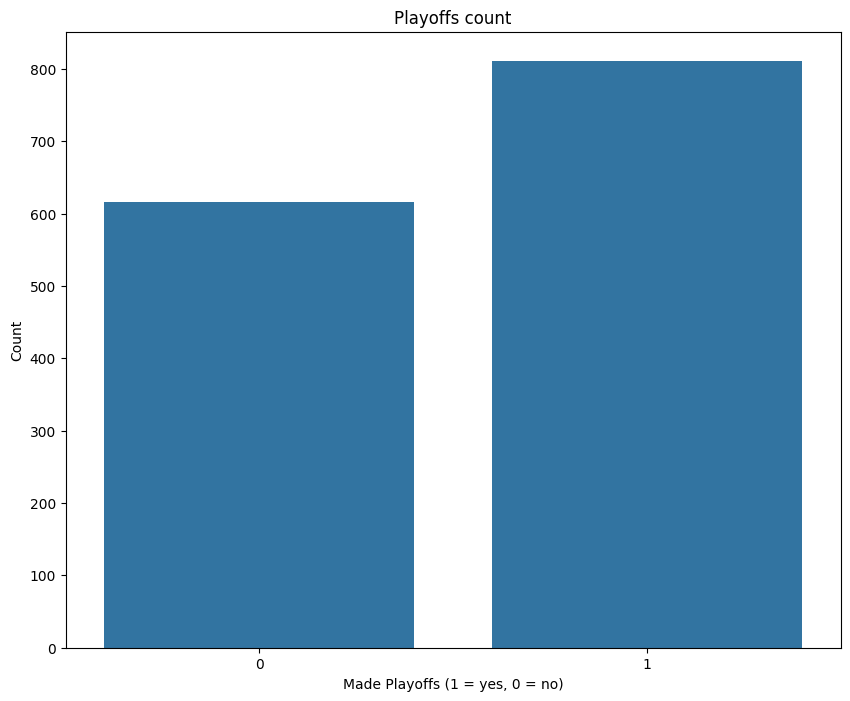

In [4]:
plt.figure(figsize=(10,8)) #See distribution of the positive and negative class
sns.countplot(x='Made_Playoffs', data = df)
plt.title('Playoffs count')
plt.xlabel('Made Playoffs (1 = yes, 0 = no)')
plt.ylabel('Count')
plt.show()

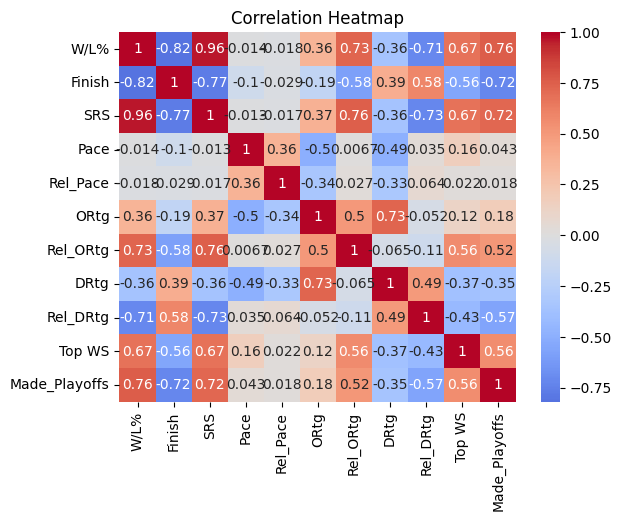

In [5]:
df_features = df.select_dtypes(include=['number'])
corr = df_features.corr()
sns.heatmap(corr, annot=True, center = 0, cmap = "coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Some attributes should have low correlation with made_playoffs as a lower score actually means better performance, thus, L (losses), DRtg (Defensive Rating), Finish (Standing), and Rel_DRtg (Reletive Defensive Rating) are expected to be like it is in the model above. The rest of the attributes are expected to be postively correlated to made_playoffs.

In [6]:
corr_target = corr['Made_Playoffs'].sort_values(ascending=False)
print(corr_target)

Made_Playoffs    1.000000
W/L%             0.760480
SRS              0.715999
Top WS           0.558262
Rel_ORtg         0.515046
ORtg             0.184441
Pace             0.043393
Rel_Pace         0.017944
DRtg            -0.354141
Rel_DRtg        -0.568003
Finish          -0.719769
Name: Made_Playoffs, dtype: float64


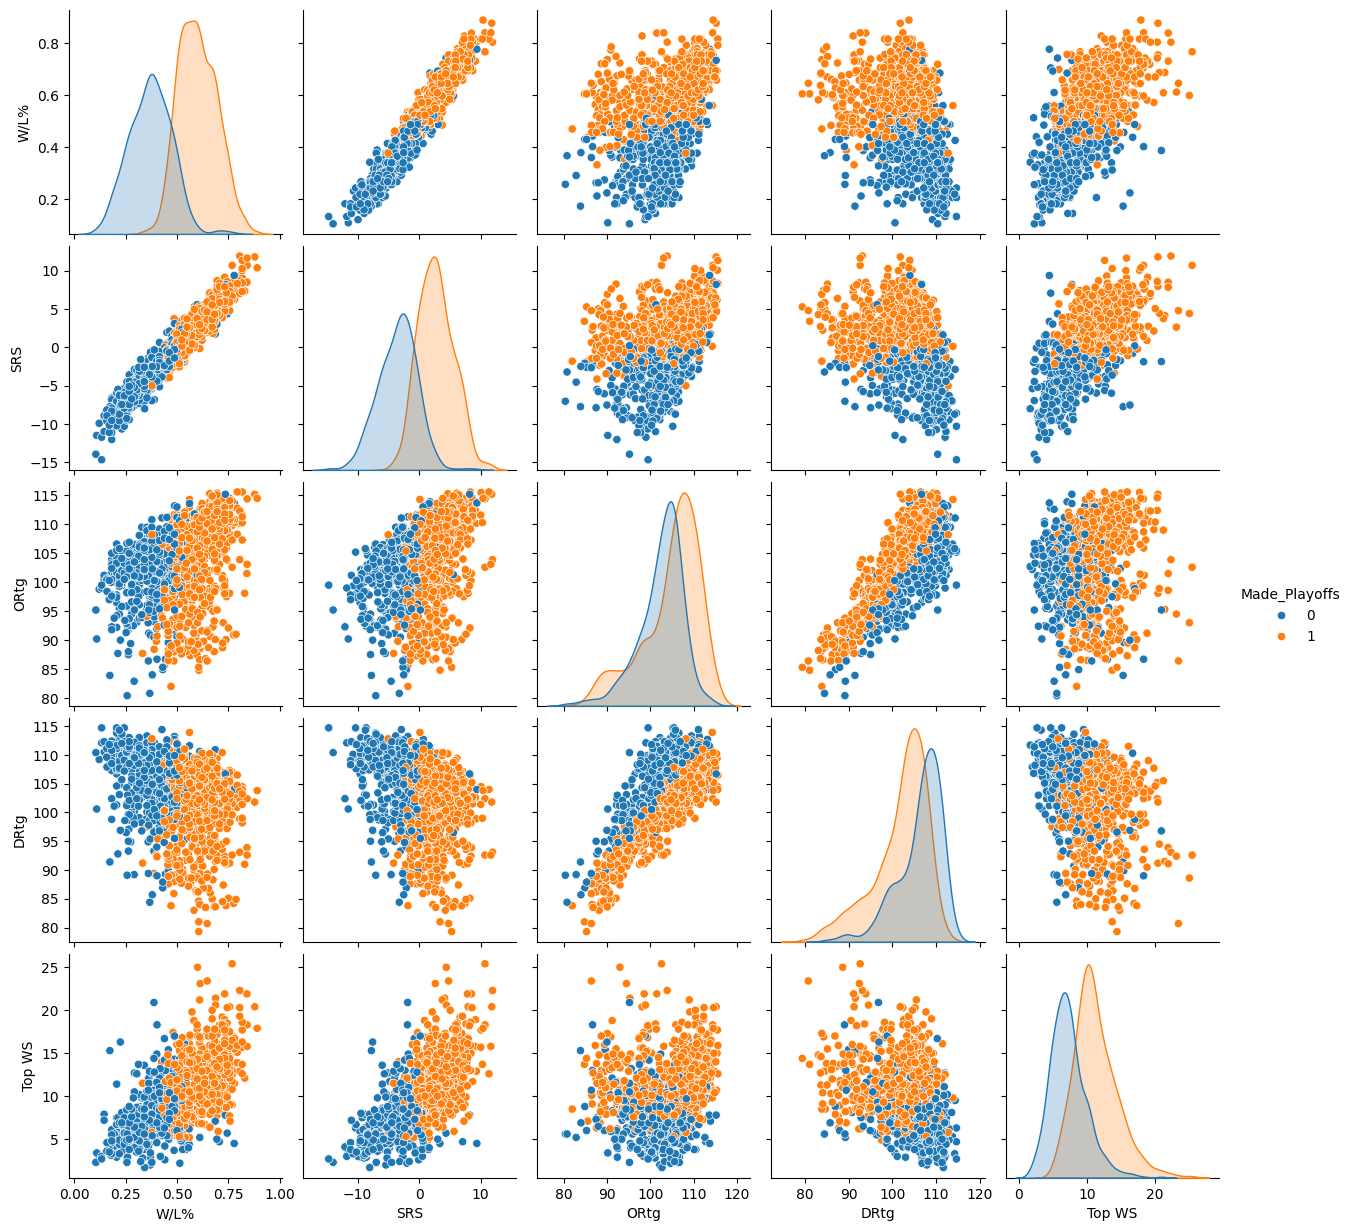

In [7]:
features = ['W/L%', 'SRS', 'ORtg', 'DRtg', 'Top WS', 'Made_Playoffs']
sns.pairplot(df[features], hue = 'Made_Playoffs')

3. Model Creation

In [8]:
#First need to establish a train test split on the data, making sure to avoid data leakage.

x = df.drop(columns=['Made_Playoffs'])
y = df['Made_Playoffs']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=17, stratify = y)

From the visualization graphs, we predicted that SVM and logistic regression may be the best models for this. Thus, we will choose these two models to do. The reason that we chose to do these is because logistic regression is good at predicting binary data and SVM is good with data that has clear linear boundaries.


Model 1: SVM

In [9]:
scaler = StandardScaler() #Normalizer
x_train_transformed = scaler.fit_transform(x_train)
x_test_transformed = scaler.transform(x_test)

svm = SVC(kernel="rbf", probability=True, class_weight="balanced")
svm.fit(x_train_transformed, y_train)
svm_pred = svm.predict(x_test_transformed)
svm_prob = svm.predict_proba(x_test_transformed)[:, 1]

print(confusion_matrix(y_test, svm_pred))

[[159  26]
 [ 24 220]]


In [10]:
svm_scores = cross_validate(svm, x_train_transformed, y_train, cv = 5, scoring = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc'])
print(f"Accuracy: {svm_scores['test_accuracy'].mean():.3f}")
print(f"F1: {svm_scores['test_f1'].mean():.3f}")
print(f"Recall: {svm_scores['test_recall'].mean():.3f}")
print(f"Precision: {svm_scores['test_precision'].mean():.3f}")
print(f"AUC: {svm_scores['test_roc_auc'].mean():.3f}")

Accuracy: 0.924
F1: 0.933
Recall: 0.929
Precision: 0.937
AUC: 0.972


Text(0, 0.5, 'True Positive Rate')

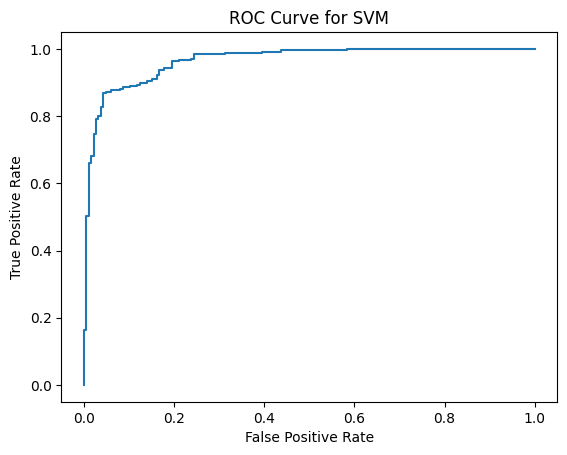

In [11]:
fpr1, tpr1, thresholds = roc_curve(y_test, svm_prob)
plt.plot(fpr1,tpr1)
plt.title("ROC Curve for SVM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Model 2: Logistic Regression

In [12]:
LogReg = LogisticRegression(random_state = 17, class_weight="balanced")
LogReg.fit(x_train_transformed, y_train)
LogReg_pred = LogReg.predict(x_test_transformed)
LogReg_prob = LogReg.predict_proba(x_test_transformed)[:, 1]

print(confusion_matrix(y_test, LogReg_pred))

[[157  28]
 [ 22 222]]


In [13]:
log_scores = cross_validate(LogReg, x_train_transformed, y_train, cv = 5, scoring = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc'])
print(f"Accuracy: {log_scores['test_accuracy'].mean():.3f}")
print(f"F1: {log_scores['test_f1'].mean():.3f}")
print(f"Recall: {log_scores['test_recall'].mean():.3f}")
print(f"Precision: {log_scores['test_precision'].mean():.3f}")
print(f"AUC: {log_scores['test_roc_auc'].mean():.3f}")

Accuracy: 0.914
F1: 0.924
Recall: 0.917
Precision: 0.930
AUC: 0.969


In [14]:
feature_names_1 = x_train.columns
coef1 = LogReg.coef_[0]
coef_df = pd.DataFrame({'Feature': feature_names_1, 'Coefficient': coef1})
coef_df

,Feature,Coefficient
0,W/L%,2.582456
1,Finish,-1.182552
2,SRS,-1.030099
3,Pace,0.047683
4,Rel_Pace,0.139838
5,ORtg,0.288981
6,Rel_ORtg,0.577332
7,DRtg,-0.462230
8,Rel_DRtg,-0.928521
9,Top WS,0.758525


Text(0, 0.5, 'True Positive Rate')

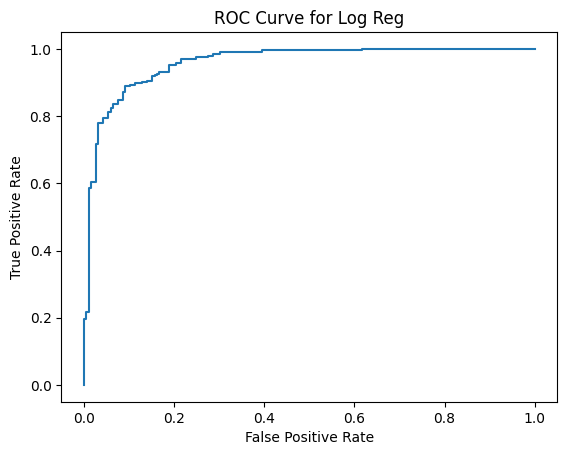

In [15]:
fpr2, tpr2, thresholds = roc_curve(y_test, LogReg_prob)
plt.plot(fpr2,tpr2)
plt.title("ROC Curve for Log Reg")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Model 3: KNN

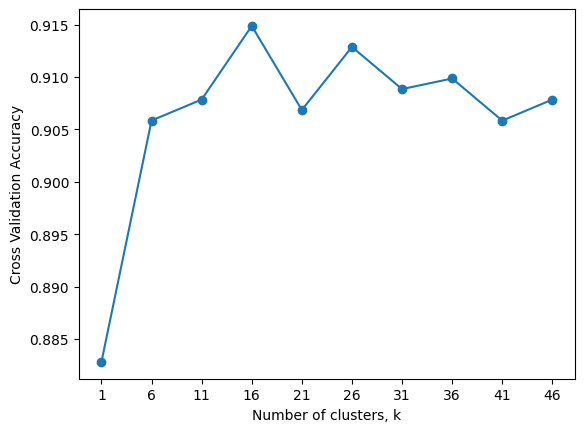

In [16]:
ks = range(1,50,5)
cv = []
for i in ks:
  knn_elbow = KNeighborsClassifier(n_neighbors = i)
  score = cross_validate(knn_elbow, x_train_transformed, y_train, cv = 5, scoring = 'accuracy')
  cv.append(score['test_score'].mean())

plt.figure()
plt.plot(ks, cv, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Cross Validation Accuracy')
plt.xticks(ks)
plt.show()

As we can see in the elbow curve above, the best k is 11.

In [17]:
knn = KNeighborsClassifier(n_neighbors = 11, weights = "distance")
knn.fit(x_train_transformed, y_train)
knn_pred = knn.predict(x_test_transformed)
knn_prob = knn.predict_proba(x_test_transformed)[:, 1]

print(confusion_matrix(y_test, knn_pred))

[[150  35]
 [ 14 230]]


In [18]:
knn_scores = cross_validate(knn, x_train_transformed, y_train, cv = 5, scoring = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc'])
print(f"Accuracy: {knn_scores['test_accuracy'].mean():.3f}")
print(f"F1: {knn_scores['test_f1'].mean():.3f}")
print(f"Recall: {knn_scores['test_recall'].mean():.3f}")
print(f"Precision: {knn_scores['test_precision'].mean():.3f}")
print(f"AUC: {knn_scores['test_roc_auc'].mean():.3f}")

Accuracy: 0.908
F1: 0.921
Recall: 0.944
Precision: 0.900
AUC: 0.966


Text(0, 0.5, 'True Positive Rate')

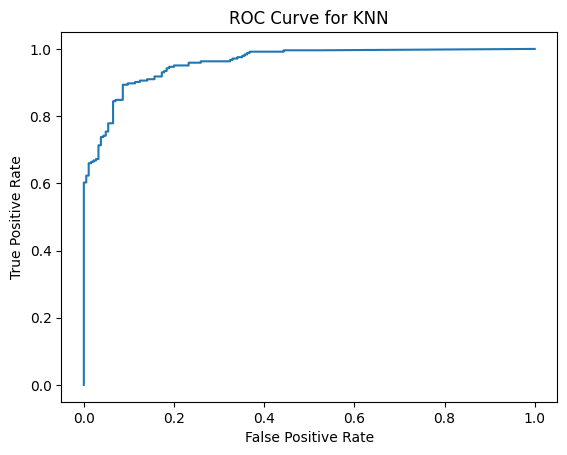

In [19]:
fpr3, tpr3, thresholds = roc_curve(y_test, knn_prob)
plt.plot(fpr3,tpr3)
plt.title("ROC Curve for KNN")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Summary

In [20]:
data = {
    'Model': ['SVM', 'Logistic Regression', 'KNN'],
    'Accuracy': [svm_scores['test_accuracy'].mean(), log_scores['test_accuracy'].mean(), knn_scores['test_accuracy'].mean()],
    'F1': [svm_scores['test_f1'].mean(), log_scores['test_f1'].mean(), knn_scores['test_f1'].mean()],
    'Precision': [svm_scores['test_precision'].mean(), log_scores['test_precision'].mean(), knn_scores['test_precision'].mean()],
    'Recall': [svm_scores['test_recall'].mean(), log_scores['test_recall'].mean(), knn_scores['test_recall'].mean()],
    'AUC': [svm_scores['test_roc_auc'].mean(), log_scores['test_roc_auc'].mean(), knn_scores['test_roc_auc'].mean()]
}

pd.DataFrame(data)

,Model,Accuracy,F1,Precision,Recall,AUC
0,SVM,0.923874,0.932757,0.936529,0.929467,0.972123
1,Logistic Regression,0.913879,0.923648,0.930467,0.917125,0.968885
2,KNN,0.907834,0.920899,0.899958,0.943549,0.966420


Notes on the Project:
- Consider removing win percentage as it is too highly correlated, inflating the score for each model.
- Consider rebalancing the dataset of some sort or more specifically, adding instances
- Consider changing to a train-test-validation split to optimize the metrics even more

Part 2:
We will now drop the three highest correlated features (win percentage, srs, and finish) to see if the model performance is still the same.

In [21]:
df = pd.read_csv(file)
df['Made_Playoffs'] = df['Playoffs'].notna().astype(int)

df = df[df['Lg'] == 'NBA'] #Only tracking NBA teams

drop_cols = ['Season','Playoffs', 'Coaches','Team','Lg','W','L','W/L%', 'SRS', 'Finish']#Categories that do not help classify. Dimensionality Reduction.
#Note that W and L are dropped as we already have W/L % and teams with incomplete seasons may act as false data for W and L.
df.drop(columns=drop_cols, inplace=True)

df['Top WS'] = df['Top WS'].apply(strip_ws)

df = df.dropna().reset_index(drop=True)
df.head()

,Pace,Rel_Pace,ORtg,Rel_ORtg,DRtg,Rel_DRtg,Top WS,Made_Playoffs
0,95.4,-1.7,108.0,0.2,102.8,-5.0,5.7,0
1,96.8,0.4,111.2,2.4,108.4,-0.4,12.5,1
2,98.5,2.7,106.8,0.4,103.6,-2.8,9.7,1
3,95.8,1.9,104.7,-0.9,104.5,-1.1,6.5,1
4,93.3,-0.6,102.9,-3.8,107.7,1.0,5.1,0


In [22]:
x2 = df.drop(columns=['Made_Playoffs'])
y2 = df['Made_Playoffs']
x2_train, x2_test , y2_train, y2_test = train_test_split(x2,y2, test_size = 0.3, random_state = 17, stratify = y2)

scaler2 = StandardScaler()
x2_train_transformed = scaler2.fit_transform(x2_train)
x2_test_transformed = scaler2.transform(x2_test)


SVM Remodeled

In [23]:
svm2 = SVC(kernel="rbf", probability=True, class_weight="balanced")
svm2.fit(x2_train_transformed, y2_train)

svm2_pred_test = svm2.predict(x2_test_transformed)
svm2_prob_test = svm2.predict_proba(x2_test_transformed)[:, 1]

Text(0, 0.5, 'True Positive Rate')

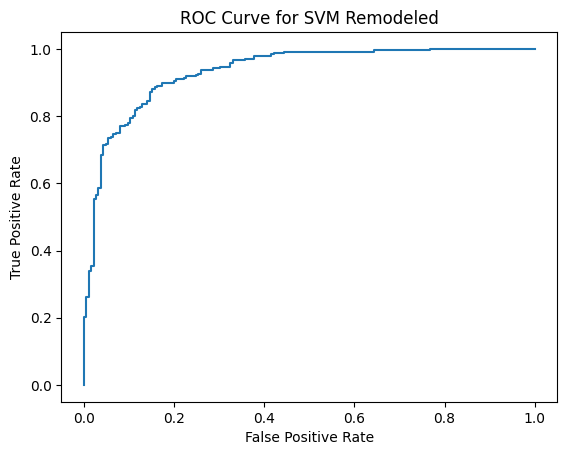

In [24]:
fpr4, tpr4, thresholds = roc_curve(y2_test, svm2_prob_test)
plt.plot(fpr4,tpr4)
plt.title("ROC Curve for SVM Remodeled")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Logistical Regression Remodeled

In [25]:
LogReg2 = LogisticRegression(random_state = 17, class_weight="balanced")
LogReg2.fit(x2_train_transformed, y2_train)

LogReg2_pred_test = LogReg2.predict(x2_test_transformed)
LogReg2_prob_test = LogReg2.predict_proba(x2_test_transformed)[:, 1]

In [26]:
feature_names = x2_train.columns
coef2 = LogReg2.coef_[0]
coef_df2 = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef2})
coef_df2

,Feature,Coefficient
0,Pace,0.114337
1,Rel_Pace,0.133416
2,ORtg,0.765476
3,Rel_ORtg,1.669997
4,DRtg,-1.009741
5,Rel_DRtg,-1.897152
6,Top WS,0.723484


Text(0, 0.5, 'True Positive Rate')

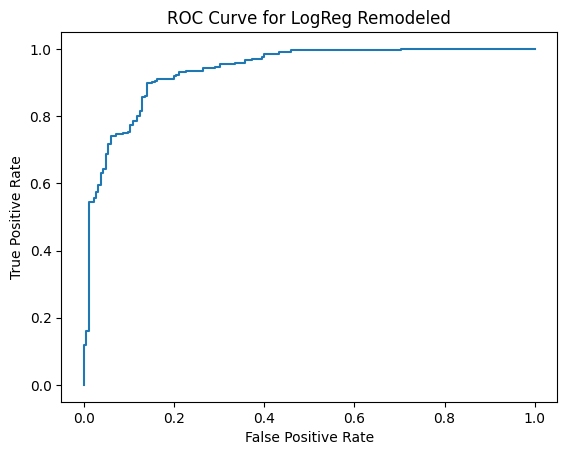

In [27]:
fpr5, tpr5, thresholds = roc_curve(y2_test, LogReg2_prob_test)
plt.plot(fpr5,tpr5)
plt.title("ROC Curve for LogReg Remodeled")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

KNN Remodeled

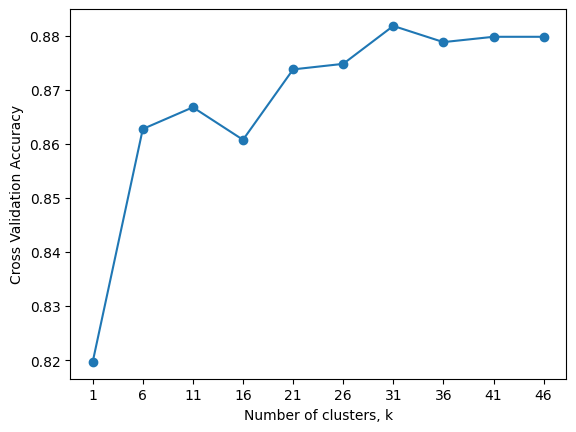

In [28]:
cv2 = []
for i in ks:
  knn_elbow = KNeighborsClassifier(n_neighbors = i)
  score = cross_validate(knn_elbow, x2_train_transformed, y2_train, cv = 5, scoring = 'accuracy')
  cv2.append(score['test_score'].mean())

plt.figure()
plt.plot(ks, cv2, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Cross Validation Accuracy')
plt.xticks(ks)
plt.show()

In [29]:
knn2 = KNeighborsClassifier(n_neighbors = 11, weights = "distance")
knn2.fit(x2_train_transformed, y2_train)

knn2_pred_test = knn2.predict(x2_test_transformed)
knn2_prob_test = knn2.predict_proba(x2_test_transformed)[:, 1]

Text(0, 0.5, 'True Positive Rate')

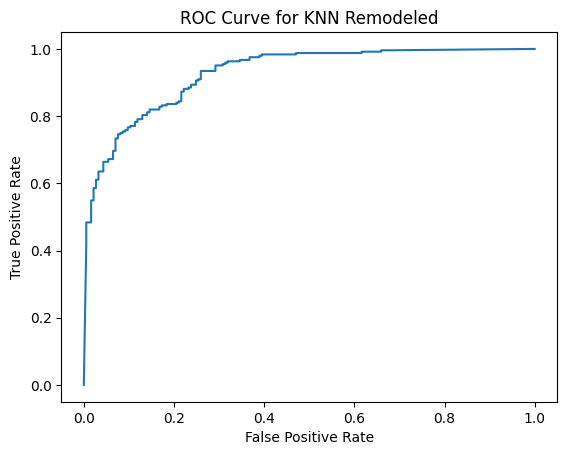

In [30]:
fpr6, tpr6, thresholds = roc_curve(y2_test, knn2_prob_test)
plt.plot(fpr6,tpr6)
plt.title("ROC Curve for KNN Remodeled")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [31]:
svm2_scores = cross_validate(svm2, x2_train_transformed, y2_train, cv = 5, scoring = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc'])
log2_scores = cross_validate(LogReg2, x2_train_transformed, y2_train, cv = 5, scoring = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc'])
knn2_scores = cross_validate(knn2, x2_train_transformed, y2_train, cv = 5, scoring = ['accuracy', 'f1', 'recall', 'precision', 'roc_auc'])

data = {
    'Model': ['SVM Remodeled', 'Logistic Regression Remodeled', 'KNN Remodeled'],
    'Accuracy': [svm2_scores['test_accuracy'].mean(), log2_scores['test_accuracy'].mean(), knn2_scores['test_accuracy'].mean()],
    'F1': [svm2_scores['test_f1'].mean(), log2_scores['test_f1'].mean(), knn2_scores['test_f1'].mean()],
    'Precision': [svm2_scores['test_precision'].mean(), log2_scores['test_precision'].mean(), knn2_scores['test_precision'].mean()],
    'Recall': [svm2_scores['test_recall'].mean(), log2_scores['test_recall'].mean(), knn2_scores['test_recall'].mean()],
    'AUC': [svm2_scores['test_roc_auc'].mean(), log2_scores['test_roc_auc'].mean(), knn2_scores['test_roc_auc'].mean()]
}

pd.DataFrame(data)

,Model,Accuracy,F1,Precision,Recall,AUC
0,SVM Remodeled,0.886824,0.900128,0.901276,0.899581,0.952906
1,Logistic Regression Remodeled,0.881829,0.893782,0.910827,0.878451,0.950636
2,KNN Remodeled,0.861749,0.882586,0.855158,0.913616,0.938830
